# Mapserver / City

In [1]:
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from AlertaDengue.AlertaDengue.settings import MAPSERVER_URL

import geopandas as gpd
import numpy as np
import os
# local
import AlertaDengue as alert_dengue

## Setting variables

In [2]:
shp_path = '%s/static/shapefile' % alert_dengue.__path__[0]

local_mapfile_dir = '%s/mapfiles/%%s' % (
    os.path.dirname(alert_dengue.__path__[0])
)

ms_shp_path = '/shapefiles'
ms_error_path = '/var/log/mapserver.log'
ms_cgi_path = MAPSERVER_URL + '?map=%s&'
ms_mapfile_name = '%s.map'
ms_mapfile_dir = '/maps/%s'

In [3]:
alert_colors = [
    '#00FF00',
    '#FFFF00',
    '#FF9900',
    '#FF0000',
]

In [4]:
# Rio de Janeiro's conf
geocode = 3304557
city_name = 'Rio de Janeiro'
# extent = '-4889577.9629838 -2648998.9936479 -4780083.386022 -2589072.9076081'

# Curitiba's conf
# geocode = 4106902
# city_name = 'Curitiba'
# extent = '-5502641.8656547 -2956723.5629958 -5471754.0373563 -2915478.1395794'

alert_level = 2
disease = 'dengue'

## Check Shapefile

In [5]:
def extract_boundaries(gdf: gpd.GeoDataFrame):
    """
    """
    bound_min = gdf.bounds[['minx', 'miny']].min()
    bound_max = gdf.bounds[['maxx', 'maxy']].max()
    bounds = np.array((bound_min, bound_max)).flatten()
    return bounds

def calc_layer_width_by_boundaries(bounds: np.array, layer_height: int=400):
    # ratio size
    width = np.abs(bounds[0] - bounds[2])
    height = np.abs(bounds[1] - bounds[3])
    
    ratio_size =  width / height

    return layer_height * ratio_size

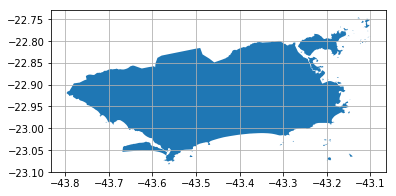

In [6]:
gdf = gpd.GeoDataFrame.from_file(os.path.join(shp_path, '%s.shp' % geocode))
gdf.plot()

plt.grid(True)
plt.show()

In [7]:
# boundaries
bounds = extract_boundaries(gdf)
bounds

array([-43.79653853, -23.0828927 , -43.0990394 , -22.74602029])

In [11]:
str_boundaries = [str(v) for v in bounds]
extent = ' '.join(str_boundaries)
extent_url = ','.join(str_boundaries)

In [12]:
# crs/srs
gdf.crs

{'init': 'epsg:4326'}

In [13]:
crs_proj = gdf.crs['init']
wms_srs = crs_proj.upper()

In [14]:
layer_height = 400
layer_width = calc_layer_width_by_boundaries(bounds)

## Mapfile

### Templates

In [15]:
# mapfile templates

mapfile_template = '''
MAP
    # The geographic extent (the rectangular area covered by the map) is 
    # defined by the keyword EXTENT. The rectangular area is specified by
    # the coordinates of the opposite corners (the lower left and the upper 
    # right). These are coordinates of the southwest and the northeast corners 
    # EX:
    # EXTENT -125.00 20.00 -65.00 50.00
    # The geographic extent stretches from 125° west, 20° north to 65° west, 
    # 50° north.
    
    CONFIG 'ON_MISSING_DATA' 'IGNORE'
    CONFIG 'PROJ_LIB' './conf/'
    CONFIG      "MS_ERRORFILE" "%(ms_error_path)s"
    CONFIG      "CPL_DEBUG" "ON"
    CONFIG      "PROJ_DEBUG" "ON"
    DEBUG       5
    
    NAME        "MAP_%(mapfile_name)s"
    
    IMAGETYPE   png
    IMAGECOLOR  0 0 0
    MAXSIZE     4000
    SIZE        800 800
    UNITS       meters
    EXTENT %(extent)s
       
    OUTPUTFORMAT
      NAME      "png"
      DRIVER    AGG/PNG
      MIMETYPE  "image/png"
      IMAGEMODE RGBA
      EXTENSION "png"
      FORMATOPTION "GAMMA=0.75"
    END
    
    OUTPUTFORMAT
      NAME "GTiff"
      DRIVER GDAL/GTiff
      MIMETYPE "image/tiff"
      IMAGEMODE RGBA
      EXTENSION "tif"
    END
    
    OUTPUTFORMAT
      NAME "kml"
      DRIVER KML
      MIMETYPE "application/vnd.google-earth.kml+xml"
      IMAGEMODE RGBA
      EXTENSION "kml"
      FORMATOPTION 'ATTACHMENT=%(mapfile_name)s.kml'
    END

    PROJECTION
        "init=%(crs_proj)s"
    END

    WEB
      METADATA
        "wms_title" "Alerta Dengue"
        "wms_onlineresource" "%(ms_cgi_path)s"
        "wms_enable_request" "*"
        "wms_srs" "%(wms_srs)s EPSG:3857 CRS:84"
        "wms_getmap_formatlist" "png,kml,gtiff"
        "labelcache_map_edge_buffer" "-10"
        # "wms_feature_info_mime_type" "text/html"
        # "wms_format" "image/png"
      END
      
      IMAGEPATH '/tmp/map/'
      IMAGEURL '/mapimg/'

    END
    
    SHAPEPATH '%(shp_path)s/'
 
%(include_layers)s
 
END
'''

mapfile_layer_template = '''
    LAYER
        NAME         "%(city_name)s"
        DATA         "%(geocode)s"
        STATUS       ON
        TYPE         POLYGON
        # OFFSITE      0 0 0
        
        TEMPLATE "conf/template.html"
        
        PROJECTION
          "init=%(crs_proj)s"
        END
        
        METADATA
          "wms_title" "%(city_name)s"
          "wms_srs" "%(wms_srs)s EPSG:3857 CRS:84"
          "wms_include_items" "all" 
          "wms_formatlist" "png,gtiff,kml"
        END
        
        # COMPOSITE
        #     OPACITY 70
        # END # COMPOSITE
 
        CLASS
            STYLE
                COLOR '%(rgb)s'
            END
        END
    END
'''

### Generating the mapfile

In [16]:
alert_color = (
    alert_colors[alert_level] if 0 <= alert_level <= 3 else
    '#DFDFDF'  # gray
)

layer_conf = {
    'geocode': geocode,
    'city_name': city_name.upper().replace(' ', '_'),
    'rgb': alert_color,
    'wms_srs': wms_srs,
    'crs_proj': crs_proj
}

layers = [layer_conf]

In [17]:
# save mapfile

include_layers = ''
include_template = '    INCLUDE "layers/%s"  # %s\n'

# save individual layers
for layer_conf in layers:
    layer_content = mapfile_layer_template % layer_conf
    layer_name = 'dengue-%s.map' % layer_conf['geocode']
    layer_path = local_mapfile_dir % ('/layers/%s' % layer_name)
    
    include_layers += include_template % (layer_name, layer_conf['city_name'])
    
    with open(layer_path, 'w') as f:
        f.write(layer_content)

# save city map file
mapfile_name = ms_mapfile_name % (
    '%s-%s' % (disease, city_name.replace(' ', '-'))
)
mapfile_path = local_mapfile_dir % mapfile_name
ms_mapfile_path = ms_mapfile_dir % mapfile_name

ms_config = {
    'include_layers': include_layers,
    'ms_error_path': ms_error_path,
    'ms_cgi_path': ms_cgi_path % ms_mapfile_path,
    'shp_path': ms_shp_path,
    'extent': extent,
    'mapfile_name': city_name.upper().replace(' ', '_'),
    'wms_srs': wms_srs,
    'crs_proj': crs_proj
}

mapfile_content = mapfile_template % ms_config

print('Saving ', mapfile_path, 'file ...')
with open(mapfile_path, 'w') as f:
    f.write(mapfile_content)

Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/dengue-Rio-de-Janeiro.map file ...


## Visualizing the map

In [18]:
HTML('''
<script type="text/javascript">
    var extent_url = '%s';
    var crs_proj = '%s';
    var mapserver_url = '%s';
    var layerWidth = %s;
    var layerHeight = %s
</script>
''' % (extent_url, crs_proj, MAPSERVER_URL, layer_width, layer_height))

In [21]:
%%html
<div><h2>dengue.map</h2>&nbsp;</div>

<div id="dengue" style="height: 400px; width: 800px;"></div>

<link rel="stylesheet" href="lib/leaflet/leaflet.css" />
<script type="text/javascript" src="lib/leaflet/leaflet.js"></script>

<script>

var mapfile_url = (
    mapserver_url + '?' + 
    'map=/maps/dengue.map&' + 
    'SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYERS=RIO_DE_JANEIRO&' +
    'STYLES=&SRS=' + crs_proj + '&BBOX=' + extent_url + '&' +
    'WIDTH=' + layerWidth + '&HEIGHT=' + layerHeight + '&FORMAT=image/png'
);

console.log(mapfile_url);

var osmUrl='http://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png';
var osmAttrib = 'Map data © <a href="http://openstreetmap.org">OpenStreetMap</a> contributors';

var minZoom = 9;
var maxZoom = 11;
var zoom = 10;

//# openstreetmap
osm = L.tileLayer(osmUrl, {
    attribution: osmAttrib,
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom
});

//# mapserver
ms = L.tileLayer.wms(mapfile_url, {
    layers: 'RIO_DE_JANEIRO',
    format: 'image/png',
    transparent: true,
    attribution: "Info Dengue",
    srs:"EPSG:4326",
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom,
});

var baseMap = {
    "OSM": osm
};

var overlayMaps = {
    "Rio Alerta": ms
};

var map = L.map(
    'dengue', {
        //crs: L.CRS.EPSG4326,
        center: new L.LatLng(-22.9192,-43.4441),
        zoom: zoom,
        layers: [osm]
    }
); 

L.control.layers(baseMap, overlayMaps).addTo(map);

</script>

In [20]:
%%html
<div><h2>dengue-Rio-de-Janeiro.map</h2>&nbsp;</div>

<div id="dengue_rio" style="height: 400px; width: 800px;"></div>

<link rel="stylesheet" href="lib/leaflet/leaflet.css" />
<script type="text/javascript" src="lib/leaflet/leaflet.js"></script>

<script>

var mapfile_url = (
    mapserver_url + '?' + 
    'map=/maps/dengue-Rio-de-Janeiro.map&' + 
    'SERVICE=WMS&VERSION=1.1.1&REQUEST=GetMap&LAYERS=RIO_DE_JANEIRO&' +
    'STYLES=&SRS=' + crs_proj + '&BBOX=' + extent_url + '&' +
    'WIDTH=400&HEIGHT=300&FORMAT=image/png'
);

console.log(mapfile_url);

var osmUrl='http://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png';
var osmAttrib = 'Map data © <a href="http://openstreetmap.org">OpenStreetMap</a> contributors';

var minZoom = 9;
var maxZoom = 11;
var zoom = 10;

//# openstreetmap
osm = L.tileLayer(osmUrl, {
    attribution: osmAttrib,
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom
});

//# mapserver
ms = L.tileLayer.wms(mapfile_url, {
    layers: 'RIO_DE_JANEIRO',
    format: 'image/png',
    transparent: true,
    attribution: "Info Dengue",
    srs:"EPSG:4326",
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom,
});

var baseMap = {
    "OSM": osm
};

var overlayMaps = {
    "Rio Alerta": ms
};

var map = L.map(
    'dengue_rio', {
        //crs: L.CRS.EPSG4326,
        center: new L.LatLng(-22.9192,-43.4441),
        zoom: zoom,
        layers: [osm]
    }
); 

L.control.layers(baseMap, overlayMaps).addTo(map);

</script>